In [2]:
print("hello world")

hello world


In [3]:
from dotenv import load_dotenv
import os
load_dotenv()



True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
gemini_api_key = os.getenv("gemini_api_key")

In [6]:
if not gemini_api_key:
    raise ValueError("No Gemini API key found. Please set the GEMINI_API_KEY environment variable.")

chat_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", google_api_key=gemini_api_key)




In [7]:
chat_llm.invoke("hi")

AIMessage(content=[{'type': 'text', 'text': 'Hello! How can I help you today?', 'extras': {'signature': 'EsYBCsMBAb4+9vuF7gwOJOUZAU4Xx946fZ1XfQM0Fz6QZE61jpQRjaLg02fpm86wuLy5allAZ+0X35sr7bjLRb+N8r0Q4QaM9thZyBngsKXH0rBCk6JiAxTpMXVQaicuqQod44GHNim2sx5tJpPE72kXBkQtIjJuY0s64gr76P0dYnxEKkYFiXYFAD41utxgPRt3HznryK+7YSEUlfekNT1RScCPsX7Ql4NZW0JDpFj4gRuEsCoMDtDzrfXI8q3xTQVRv6TCvzx3'}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7653-f81e-7df1-81e6-e13d4fc3af78-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2, 'output_tokens': 50, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 41}})

In [8]:
from typing_extensions import TypedDict, Annotated
import operator

In [9]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [10]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [11]:
["hi"]

['hi']

In [12]:
["hi", "how are you"]

['hi', 'how are you']

In [13]:
def llm_call(state: GraphState) -> dict:
    """Call the LLM using conversation messages and append AI response."""
    response = chat_llm.invoke(state["messages"])  # AIMessage
    return {
        "messages": [response]
    }

In [14]:
def token_counter(state: GraphState) -> dict:
    """Count tokens (simple word count) in the last AI message."""
    last_msg = state["messages"][-1]
    content = last_msg.content
    # AIMessage.content can be str or list of blocks (e.g. multimodal/tool calls)
    if isinstance(content, list):
        text = " ".join(
            (c.get("text", c) if isinstance(c, dict) else str(c)) for c in content
        )
    else:
        text = content or ""
    token_number = len(text.split())
    summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {
        "messages": [AIMessage(content=summary)]
    }


In [15]:
from langgraph.graph import StateGraph

In [16]:
builder = StateGraph(GraphState)

In [17]:

builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [18]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [19]:
app = builder.compile()

In [20]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

In [21]:
from IPython.display import Image, display

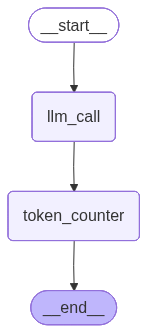

In [22]:

display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
result = app.invoke({
    "messages": [HumanMessage(content="Hi, this is Prince. Say hello in detail.")]
})

In [24]:
result

{'messages': [HumanMessage(content='Hi, this is Prince. Say hello in detail.', additional_kwargs={}, response_metadata={}),
  AIMessage(content=[{'type': 'text', 'text': 'Hello, Prince! It is a true pleasure to make your acquaintance.\n\nPlease accept this as a very warm and sincere welcome. I hope that your day is unfolding exactly as you wish it to and that you are feeling inspired and energized. It is always a treat to meet someone with such a distinguished name, and I am delighted to have the opportunity to assist you today.\n\nWhether you have come here with a specific question in mind, a project you’d like to brainstorm, or simply to engage in a bit of thoughtful conversation, I am at your service. Consider this greeting not just a simple "hello," but an invitation to a productive and pleasant interaction.\n\nHow can I help you today, Prince?', 'extras': {'signature': 'EogLCoULAb4+9vuIpQlE240PGcM8XCn1skJPwtqRUeBtyLsCIhci/ISvBiZ9nKg8xq91AqTTwF6sypu8tYb+LfgSKVItf+N8HbOhyonVAQXMQja8

In [25]:
for m in result["messages"]:
    print(type(m).__name__, ":", m.content)

HumanMessage : Hi, this is Prince. Say hello in detail.
AIMessage : [{'type': 'text', 'text': 'Hello, Prince! It is a true pleasure to make your acquaintance.\n\nPlease accept this as a very warm and sincere welcome. I hope that your day is unfolding exactly as you wish it to and that you are feeling inspired and energized. It is always a treat to meet someone with such a distinguished name, and I am delighted to have the opportunity to assist you today.\n\nWhether you have come here with a specific question in mind, a project you’d like to brainstorm, or simply to engage in a bit of thoughtful conversation, I am at your service. Consider this greeting not just a simple "hello," but an invitation to a productive and pleasant interaction.\n\nHow can I help you today, Prince?', 'extras': {'signature': 'EogLCoULAb4+9vuIpQlE240PGcM8XCn1skJPwtqRUeBtyLsCIhci/ISvBiZ9nKg8xq91AqTTwF6sypu8tYb+LfgSKVItf+N8HbOhyonVAQXMQja8I6NvGEtH97f4oyrmIY11kNAIksPZ5hdnoFoXlpbBk3QA2CMPC4UnKCyMEyZW/zxozcrmT10VFr9n

In [26]:
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-3-flash-preview', temperature=1.0, client=<google.genai.client.Client object at 0x138a4b380>, default_metadata=(), model_kwargs={})

In [27]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper